In [52]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras import Input
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

In [53]:
#loading the dataset
df = pd.read_csv('diabetes.csv')

print(df.shape)

(768, 9)


In [54]:
# Columns where 0 is invalid
cols_with_zero_invalid = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# Count how many 0s in these columns
for col in cols_with_zero_invalid:
    zero_count = (df[col] == 0).sum()
    print(f'{col}: {zero_count} zero values')

Glucose: 5 zero values
BloodPressure: 35 zero values
SkinThickness: 227 zero values
Insulin: 374 zero values
BMI: 11 zero values


In [55]:
# Replace 0s with NaN in specific columns
df[cols_with_zero_invalid] = df[cols_with_zero_invalid].replace(0, np.nan)

# Check missing values again
print(df.isnull().sum())

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64


In [56]:
# Fill NaNs with mean values
df.fillna(df.mean(numeric_only=True), inplace=True)

#rechecking for any remaining zero values
print(df.isnull().sum())


Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


In [57]:
#separate features (X) and target (y)
X = df.drop('Outcome', axis=1)
y = df['Outcome']

# split into 70% train and 30% temp 
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

# Split temp into 15% validation and 15% test 
# Since temp is 30%, we split it into half to get 15% each
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

# Confirm the sizes
print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")


Training set: (537, 8)
Validation set: (115, 8)
Test set: (116, 8)


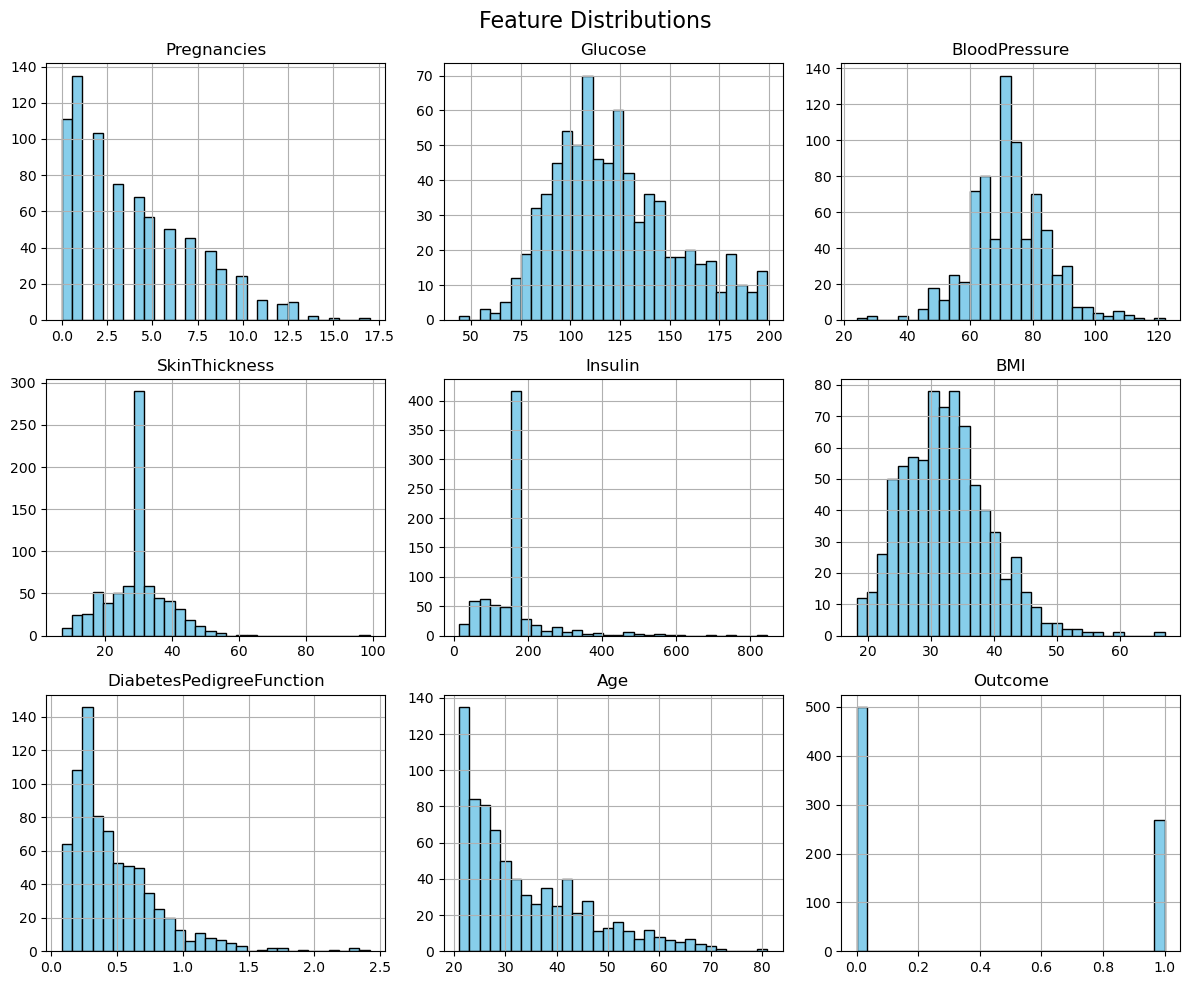

In [58]:
#visualizing featuer distribbution of the dataset
# Plot histograms for all features
df.hist(figsize=(12, 10), bins=30, color='skyblue', edgecolor='black')
plt.suptitle("Feature Distributions", fontsize=16)
plt.tight_layout()
plt.show()

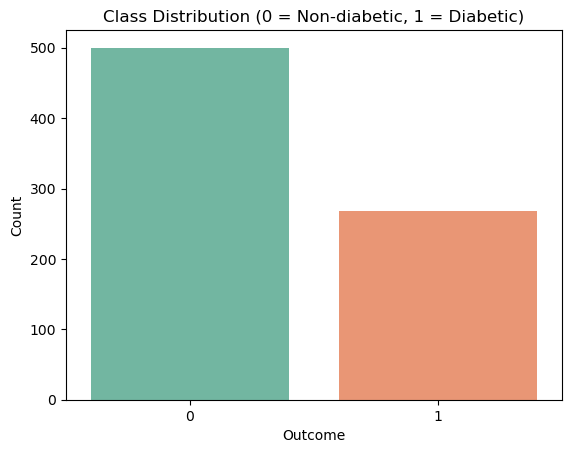

In [59]:
# visualizing class inmblances - barchart
sns.countplot(x='Outcome', data=df, palette='Set2', hue='Outcome' ,legend = False)
plt.title("Class Distribution (0 = Non-diabetic, 1 = Diabetic)")
plt.xlabel("Outcome")
plt.ylabel("Count")
plt.show()


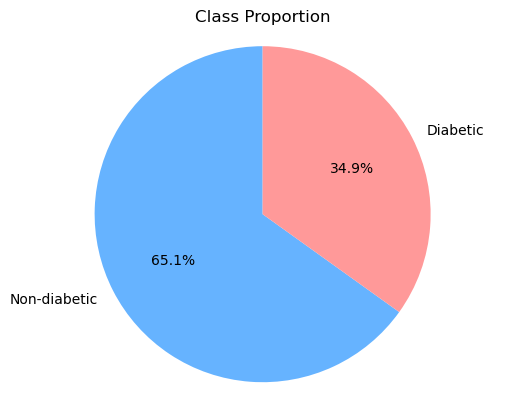

In [60]:
# # visualizing class inmblances - piechart
labels = ['Non-diabetic', 'Diabetic']
sizes = df['Outcome'].value_counts()
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#66b3ff','#ff9999'])
plt.title('Class Proportion')
plt.axis('equal')
plt.show()

In [61]:
#manual hyperparameter tuning expirementation
from keras import Input
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

# Parameter combinations to test
learning_rates = [0.01, 0.001]
hidden_units_list = [8, 16, 32]
batch_sizes = [16, 32]

results = []

for lr in learning_rates:
    for hu in hidden_units_list:
        for bs in batch_sizes:
            model = Sequential([
                Input(shape=(X_train.shape[1],)),
                Dense(hu, activation='relu'),
                Dense(hu, activation='relu'),
                Dense(1, activation='sigmoid')
            ])
            model.compile(optimizer=Adam(learning_rate=lr),
                          loss='binary_crossentropy',
                          metrics=['accuracy'])
            
            history = model.fit(
                X_train, y_train,
                validation_data=(X_val, y_val),
                epochs=50,
                batch_size=bs,
                verbose=0 
            )

            val_acc = history.history['val_accuracy'][-1]
            print(f"LR: {lr}, HU: {hu}, BS: {bs} => Val Acc: {val_acc:.4f}")
            results.append((lr, hu, bs, val_acc))

# Sort by val_accuracy in descending order
sorted_results = sorted(results, key=lambda x: x[3], reverse=True)

# Get the best configuration
best = sorted_results[0]
best_lr, best_hu, best_bs, best_acc = best

print(f"Best Configuration:\n"
      f"  Learning Rate: {best_lr}\n"
      f"  Hidden Units: {best_hu}\n"
      f"  Batch Size: {best_bs}\n"
      f"  Validation Accuracy: {best_acc:.4f}")


LR: 0.01, HU: 8, BS: 16 => Val Acc: 0.6087
LR: 0.01, HU: 8, BS: 32 => Val Acc: 0.6261
LR: 0.01, HU: 16, BS: 16 => Val Acc: 0.7217
LR: 0.01, HU: 16, BS: 32 => Val Acc: 0.7217
LR: 0.01, HU: 32, BS: 16 => Val Acc: 0.7217
LR: 0.01, HU: 32, BS: 32 => Val Acc: 0.7130
LR: 0.001, HU: 8, BS: 16 => Val Acc: 0.6435
LR: 0.001, HU: 8, BS: 32 => Val Acc: 0.6348
LR: 0.001, HU: 16, BS: 16 => Val Acc: 0.6609
LR: 0.001, HU: 16, BS: 32 => Val Acc: 0.6522
LR: 0.001, HU: 32, BS: 16 => Val Acc: 0.6870
LR: 0.001, HU: 32, BS: 32 => Val Acc: 0.5913
Best Configuration:
  Learning Rate: 0.01
  Hidden Units: 16
  Batch Size: 16
  Validation Accuracy: 0.7217


In [62]:
from keras.regularizers import l2
#optimized model qith dropout
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(best_hu, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(best_hu, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=best_lr),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Retrain model with best settings
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=best_bs,
    verbose=1
)


Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5498 - loss: 8.5459 - val_accuracy: 0.6783 - val_loss: 1.3249
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6314 - loss: 1.4419 - val_accuracy: 0.7043 - val_loss: 0.9478
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6354 - loss: 1.0425 - val_accuracy: 0.6522 - val_loss: 0.7367
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5681 - loss: 1.7765 - val_accuracy: 0.6609 - val_loss: 0.8030
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6590 - loss: 1.0480 - val_accuracy: 0.6609 - val_loss: 0.8131
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6814 - loss: 0.7083 - val_accuracy: 0.7043 - val_loss: 0.7492
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6908 - loss: 0.7465 - val_accuracy: 0.6609 - val_loss: 0.6409
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6882 - loss: 0.7382 - val_accuracy: 0.6522 - val_loss:

In [63]:
model.summary()

Model: "sequential_54"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_162 (Dense)               │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_163 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_164 (Dense)               │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,301 (5.09 KB)

 Trainable params: 433 (1.69 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 868 (3.39 KB)

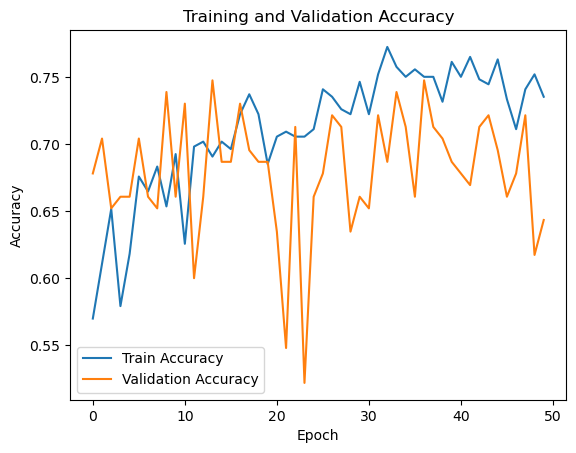

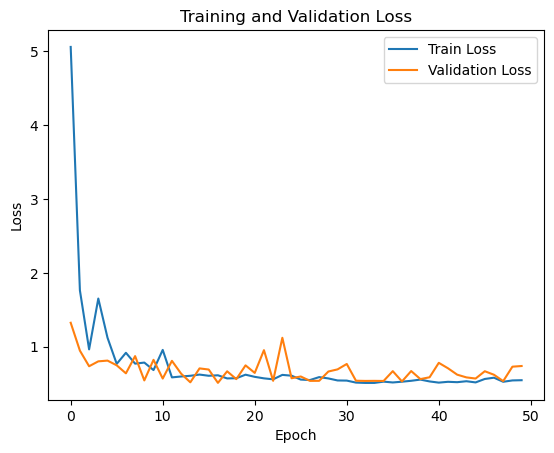

In [64]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [65]:
from keras.callbacks import EarlyStopping

# Define early stopping
early_stop = EarlyStopping(
    monitor='val_loss',           # parameter to watch
    patience=5,                   # Stop after 5 epochs without improvement
    restore_best_weights=True     # Revert to best weights after training stops
)

#optimized model with early stopping and dropout
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(best_hu, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(best_hu, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=best_lr),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Retrain model with best settings
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=best_bs,
    verbose=1
)

# Save the model
model.save('diabetes_model.h5')

Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5264 - loss: 1.2907 - val_accuracy: 0.6174 - val_loss: 0.7520
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5751 - loss: 0.7743 - val_accuracy: 0.6261 - val_loss: 0.7648
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6859 - loss: 0.6810 - val_accuracy: 0.6000 - val_loss: 1.0289
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6896 - loss: 0.6681 - val_accuracy: 0.6435 - val_loss: 0.6600
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7152 - loss: 0.6262 - val_accuracy: 0.6783 - val_loss: 0.6389
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7141 - loss: 0.6038 - val_accuracy: 0.6348 - val_loss: 0.7362
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7268 - loss: 0.6257 - val_accuracy: 0.6870 - val_loss: 0.6242
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7096 - loss: 0.5901 - val_accuracy: 0.6696 - val_loss:

In [66]:
#load the saved model
from keras.models import load_model
model = load_model('diabetes_model.h5')

# Evaluate accuracy directly
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Get predicted probabilities
y_pred_prob = model.predict(X_test)

# Convert probabilities to binary output (0 or 1)
y_pred = (y_pred_prob > 0.5).astype("int32")

Test Accuracy: 0.7845
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [67]:
from sklearn.metrics import classification_report, confusion_matrix

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))


Confusion Matrix:
[[61 14]
 [11 30]]

Classification Report:
              precision    recall  f1-score   support

           0     0.8472    0.8133    0.8299        75
           1     0.6818    0.7317    0.7059        41

    accuracy                         0.7845       116
   macro avg     0.7645    0.7725    0.7679       116
weighted avg     0.7888    0.7845    0.7861       116



ROC AUC Score: 0.8198


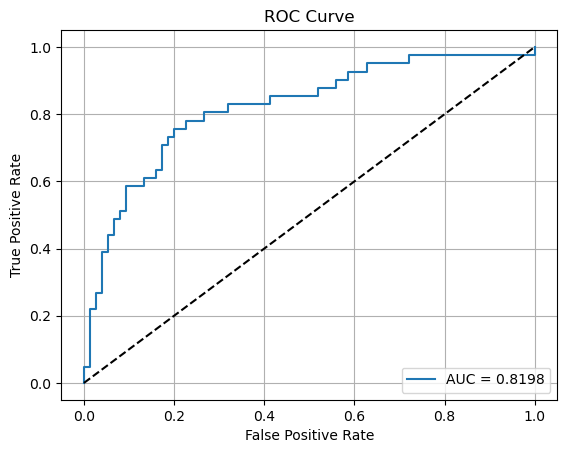

In [68]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Calculate AUC
auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC AUC Score: {auc:.4f}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')  # diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()
